# Lista de exercício 3

In [45]:
# Import all libraries to construct the model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.noise import AlphaDropout
from keras.callbacks import ModelCheckpoint
import multiprocessing as mp
import psutil
import time

In [2]:
data_path = 'wdbc.data'
df = pd.read_csv(data_path, header=None, index_col=0)
df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720


In [3]:
# Separating input data and targets
cols = [0, 1]
features, targets = df.drop(df.columns[cols],axis=1), df[1]

targets.replace('M', 1, inplace=True)
targets.replace('B', 0, inplace=True)

# Split datasets to train e test
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30, random_state=42)

In [4]:
# Defining a function to get memory usage
def monitor(target):
    worker_process = mp.Process(target=target)
    worker_process.start()
    p = psutil.Process(worker_process.pid)
    return p.memory_info()[0]/1024/1024

In [5]:
# Create this class to keep state of Keras history and show additional informations, because I'm using a monitor to ge a used memory
class KerasHistory:

    def __init__(self):
        self.info = None
        self.memory_usage = 0
        self.elapsed = 0

In [23]:
# Function of training
def train(model, X, y, keras_history, epochs=100, batch_size=20):
    start = time.time()
    
    # checkpoint
    filepath="weights1.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    #earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=400, verbose=0, mode='auto')
    
    callbacks_list = [checkpoint]

    history = model.fit(X, y, validation_split=0.20, epochs=epochs, verbose=2, callbacks=callbacks_list)
    
    keras_history.info = history
    done = time.time()
    keras_history.elapsed = done - start

In [24]:
# Show info of model
def show_info(model, X, y, keras_history):
    # list all data in history
    #print(history.history.keys())

    # summarize history for accuracy
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['acc'])
    plt.plot(keras_history.info.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['loss'])
    plt.plot(keras_history.info.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Print memory usage
    print('Memory Usage {:2.2f} MB'.format(keras_history.memory_usage))
    
    print('Time of Processing {:4.2f}s'.format(keras_history.elapsed))
    
    model.load_weights("weights1.best.hdf5")
    score = model.evaluate(X, y, verbose=0)
    print('Accuracy {:2.2f}%'.format(score[1]*100))

In [25]:
# Normalization of data
#X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
#X_test_norm = (X_test - X_test.mean()) / (X_test.max() - X_test.min())


scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [76]:
from numpy.random import seed
seed(1)

# Building the model 6
model6 = Sequential()
model6.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform'))
model6.add(Dropout(0.5))
model6.add(Dense(128, kernel_initializer='random_uniform', activation='tanh'))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
#optimizer = optimizers.RMSprop(lr=0.0001)
optimizer = optimizers.Adam(lr=0.0001)
model6.compile(loss = 'mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model6.summary()

# Training the model 6
keras_history6 = KerasHistory()
memory_usage = monitor(target=train(model6, X_train_norm, y_train, keras_history6, epochs=500, batch_size=20))
keras_history6.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 128)               3840      
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 129       
Total params: 20,481
Trainable params: 20,481
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 1s - loss: 0.2297 - acc: 0.7358 - val_loss: 0.2103 - val_acc: 0.8625
Epoch 2/5

Epoch 86/500
 - 0s - loss: 0.0188 - acc: 0.9811 - val_loss: 0.0196 - val_acc: 0.9625
Epoch 87/500
 - 0s - loss: 0.0168 - acc: 0.9843 - val_loss: 0.0193 - val_acc: 0.9625
Epoch 88/500
 - 0s - loss: 0.0161 - acc: 0.9811 - val_loss: 0.0191 - val_acc: 0.9625
Epoch 89/500
 - 0s - loss: 0.0168 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9625
Epoch 90/500
 - 0s - loss: 0.0163 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 91/500
 - 0s - loss: 0.0167 - acc: 0.9811 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 92/500
 - 0s - loss: 0.0164 - acc: 0.9843 - val_loss: 0.0190 - val_acc: 0.9750
Epoch 93/500
 - 0s - loss: 0.0177 - acc: 0.9811 - val_loss: 0.0188 - val_acc: 0.9625
Epoch 94/500
 - 0s - loss: 0.0166 - acc: 0.9811 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 95/500
 - 0s - loss: 0.0155 - acc: 0.9811 - val_loss: 0.0185 - val_acc: 0.9750
Epoch 96/500
 - 0s - loss: 0.0162 - acc: 0.9811 - val_loss: 0.0185 - val_acc: 0.9750
Epoch 97/500
 - 0s - loss: 0.0141 - acc: 0.9843 - val_loss: 0.018

Epoch 182/500
 - 0s - loss: 0.0100 - acc: 0.9906 - val_loss: 0.0186 - val_acc: 0.9750
Epoch 183/500
 - 0s - loss: 0.0120 - acc: 0.9874 - val_loss: 0.0187 - val_acc: 0.9750
Epoch 184/500
 - 0s - loss: 0.0113 - acc: 0.9874 - val_loss: 0.0184 - val_acc: 0.9750
Epoch 185/500
 - 0s - loss: 0.0112 - acc: 0.9843 - val_loss: 0.0183 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0187 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0112 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0100 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9625
Epoch 189/500
 - 0s - loss: 0.0107 - acc: 0.9906 - val_loss: 0.0188 - val_acc: 0.9625
Epoch 190/500
 - 0s - loss: 0.0126 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9625
Epoch 191/500
 - 0s - loss: 0.0101 - acc: 0.9906 - val_loss: 0.0183 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0099 - acc: 0.9874 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0113 - acc: 0.9843 - val

Epoch 278/500
 - 0s - loss: 0.0074 - acc: 0.9906 - val_loss: 0.0265 - val_acc: 0.9625
Epoch 279/500
 - 0s - loss: 0.0066 - acc: 0.9937 - val_loss: 0.0271 - val_acc: 0.9625
Epoch 280/500
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0265 - val_acc: 0.9625
Epoch 281/500
 - 0s - loss: 0.0067 - acc: 0.9969 - val_loss: 0.0265 - val_acc: 0.9625
Epoch 282/500
 - 0s - loss: 0.0069 - acc: 0.9937 - val_loss: 0.0260 - val_acc: 0.9625
Epoch 283/500
 - 0s - loss: 0.0075 - acc: 0.9937 - val_loss: 0.0261 - val_acc: 0.9625
Epoch 284/500
 - 0s - loss: 0.0080 - acc: 0.9906 - val_loss: 0.0262 - val_acc: 0.9625
Epoch 285/500
 - 0s - loss: 0.0080 - acc: 0.9906 - val_loss: 0.0258 - val_acc: 0.9625
Epoch 286/500
 - 0s - loss: 0.0081 - acc: 0.9906 - val_loss: 0.0266 - val_acc: 0.9625
Epoch 287/500
 - 0s - loss: 0.0089 - acc: 0.9906 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 288/500
 - 0s - loss: 0.0079 - acc: 0.9937 - val_loss: 0.0271 - val_acc: 0.9625
Epoch 289/500
 - 0s - loss: 0.0082 - acc: 0.9906 - val

Epoch 374/500
 - 0s - loss: 0.0062 - acc: 0.9937 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 375/500
 - 0s - loss: 0.0062 - acc: 0.9906 - val_loss: 0.0282 - val_acc: 0.9625
Epoch 376/500
 - 0s - loss: 0.0056 - acc: 0.9969 - val_loss: 0.0277 - val_acc: 0.9625
Epoch 377/500
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 378/500
 - 0s - loss: 0.0059 - acc: 0.9937 - val_loss: 0.0276 - val_acc: 0.9625
Epoch 379/500
 - 0s - loss: 0.0063 - acc: 0.9937 - val_loss: 0.0281 - val_acc: 0.9625
Epoch 380/500
 - 0s - loss: 0.0057 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 381/500
 - 0s - loss: 0.0054 - acc: 0.9969 - val_loss: 0.0293 - val_acc: 0.9625
Epoch 382/500
 - 0s - loss: 0.0059 - acc: 0.9937 - val_loss: 0.0299 - val_acc: 0.9625
Epoch 383/500
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0301 - val_acc: 0.9625
Epoch 384/500
 - 0s - loss: 0.0065 - acc: 0.9937 - val_loss: 0.0302 - val_acc: 0.9625
Epoch 385/500
 - 0s - loss: 0.0049 - acc: 0.9969 - val

Epoch 470/500
 - 0s - loss: 0.0042 - acc: 0.9969 - val_loss: 0.0331 - val_acc: 0.9625
Epoch 471/500
 - 0s - loss: 0.0051 - acc: 0.9969 - val_loss: 0.0331 - val_acc: 0.9625
Epoch 472/500
 - 0s - loss: 0.0044 - acc: 0.9969 - val_loss: 0.0331 - val_acc: 0.9625
Epoch 473/500
 - 0s - loss: 0.0046 - acc: 0.9969 - val_loss: 0.0330 - val_acc: 0.9625
Epoch 474/500
 - 0s - loss: 0.0041 - acc: 0.9969 - val_loss: 0.0329 - val_acc: 0.9625
Epoch 475/500
 - 0s - loss: 0.0053 - acc: 0.9937 - val_loss: 0.0328 - val_acc: 0.9625
Epoch 476/500
 - 0s - loss: 0.0050 - acc: 0.9969 - val_loss: 0.0323 - val_acc: 0.9625
Epoch 477/500
 - 0s - loss: 0.0051 - acc: 0.9969 - val_loss: 0.0321 - val_acc: 0.9625
Epoch 478/500
 - 0s - loss: 0.0054 - acc: 0.9969 - val_loss: 0.0327 - val_acc: 0.9625
Epoch 479/500
 - 0s - loss: 0.0046 - acc: 0.9969 - val_loss: 0.0327 - val_acc: 0.9625
Epoch 480/500
 - 0s - loss: 0.0048 - acc: 0.9969 - val_loss: 0.0325 - val_acc: 0.9625
Epoch 481/500
 - 0s - loss: 0.0052 - acc: 0.9937 - val

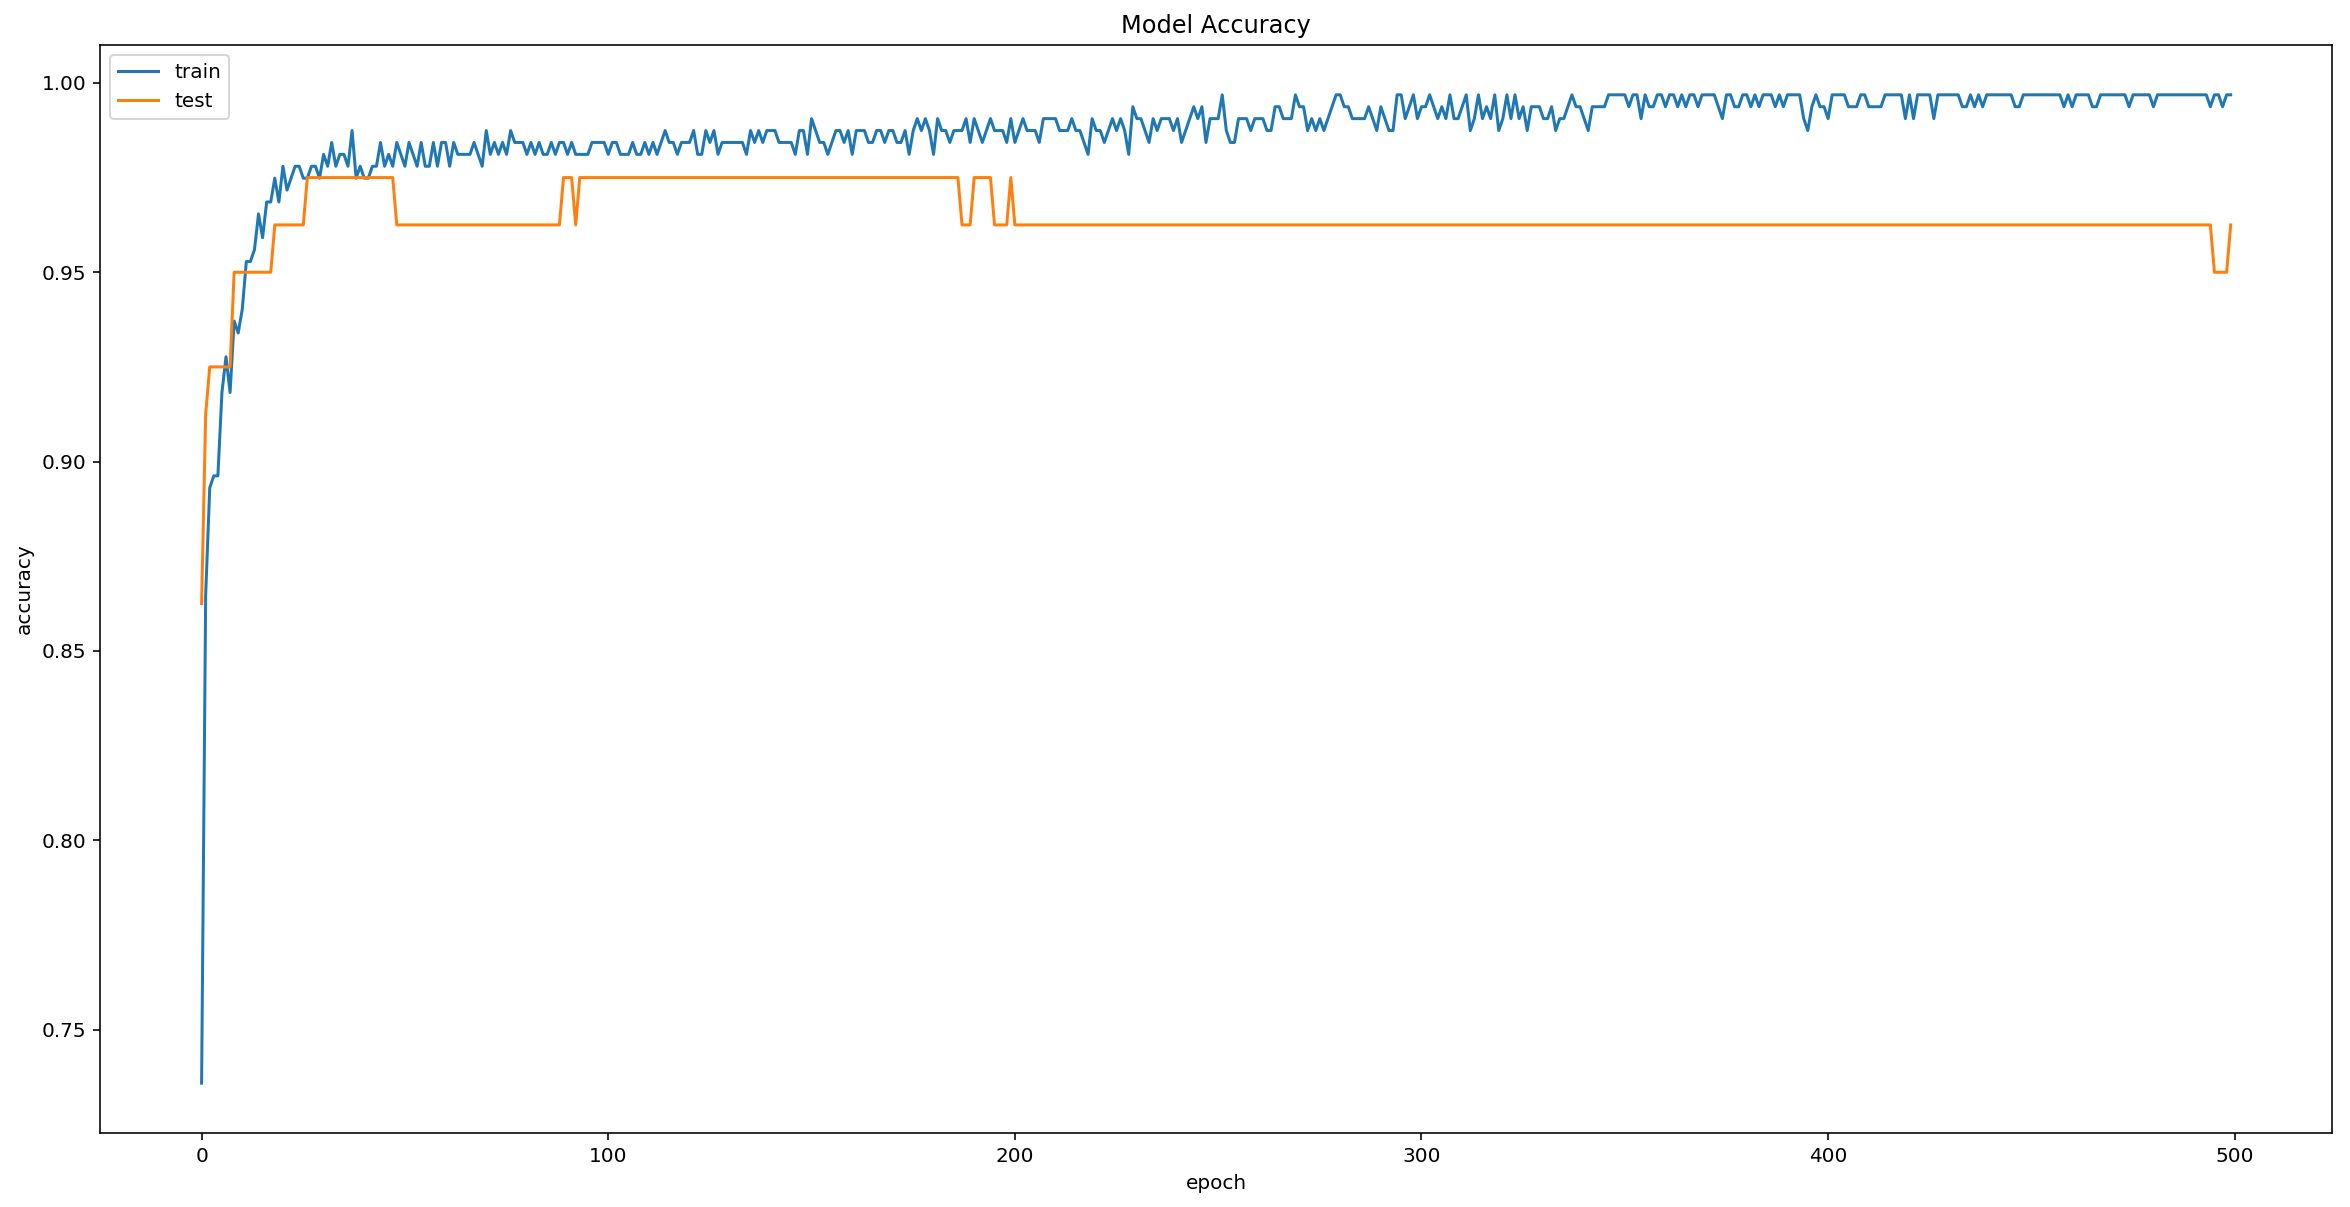

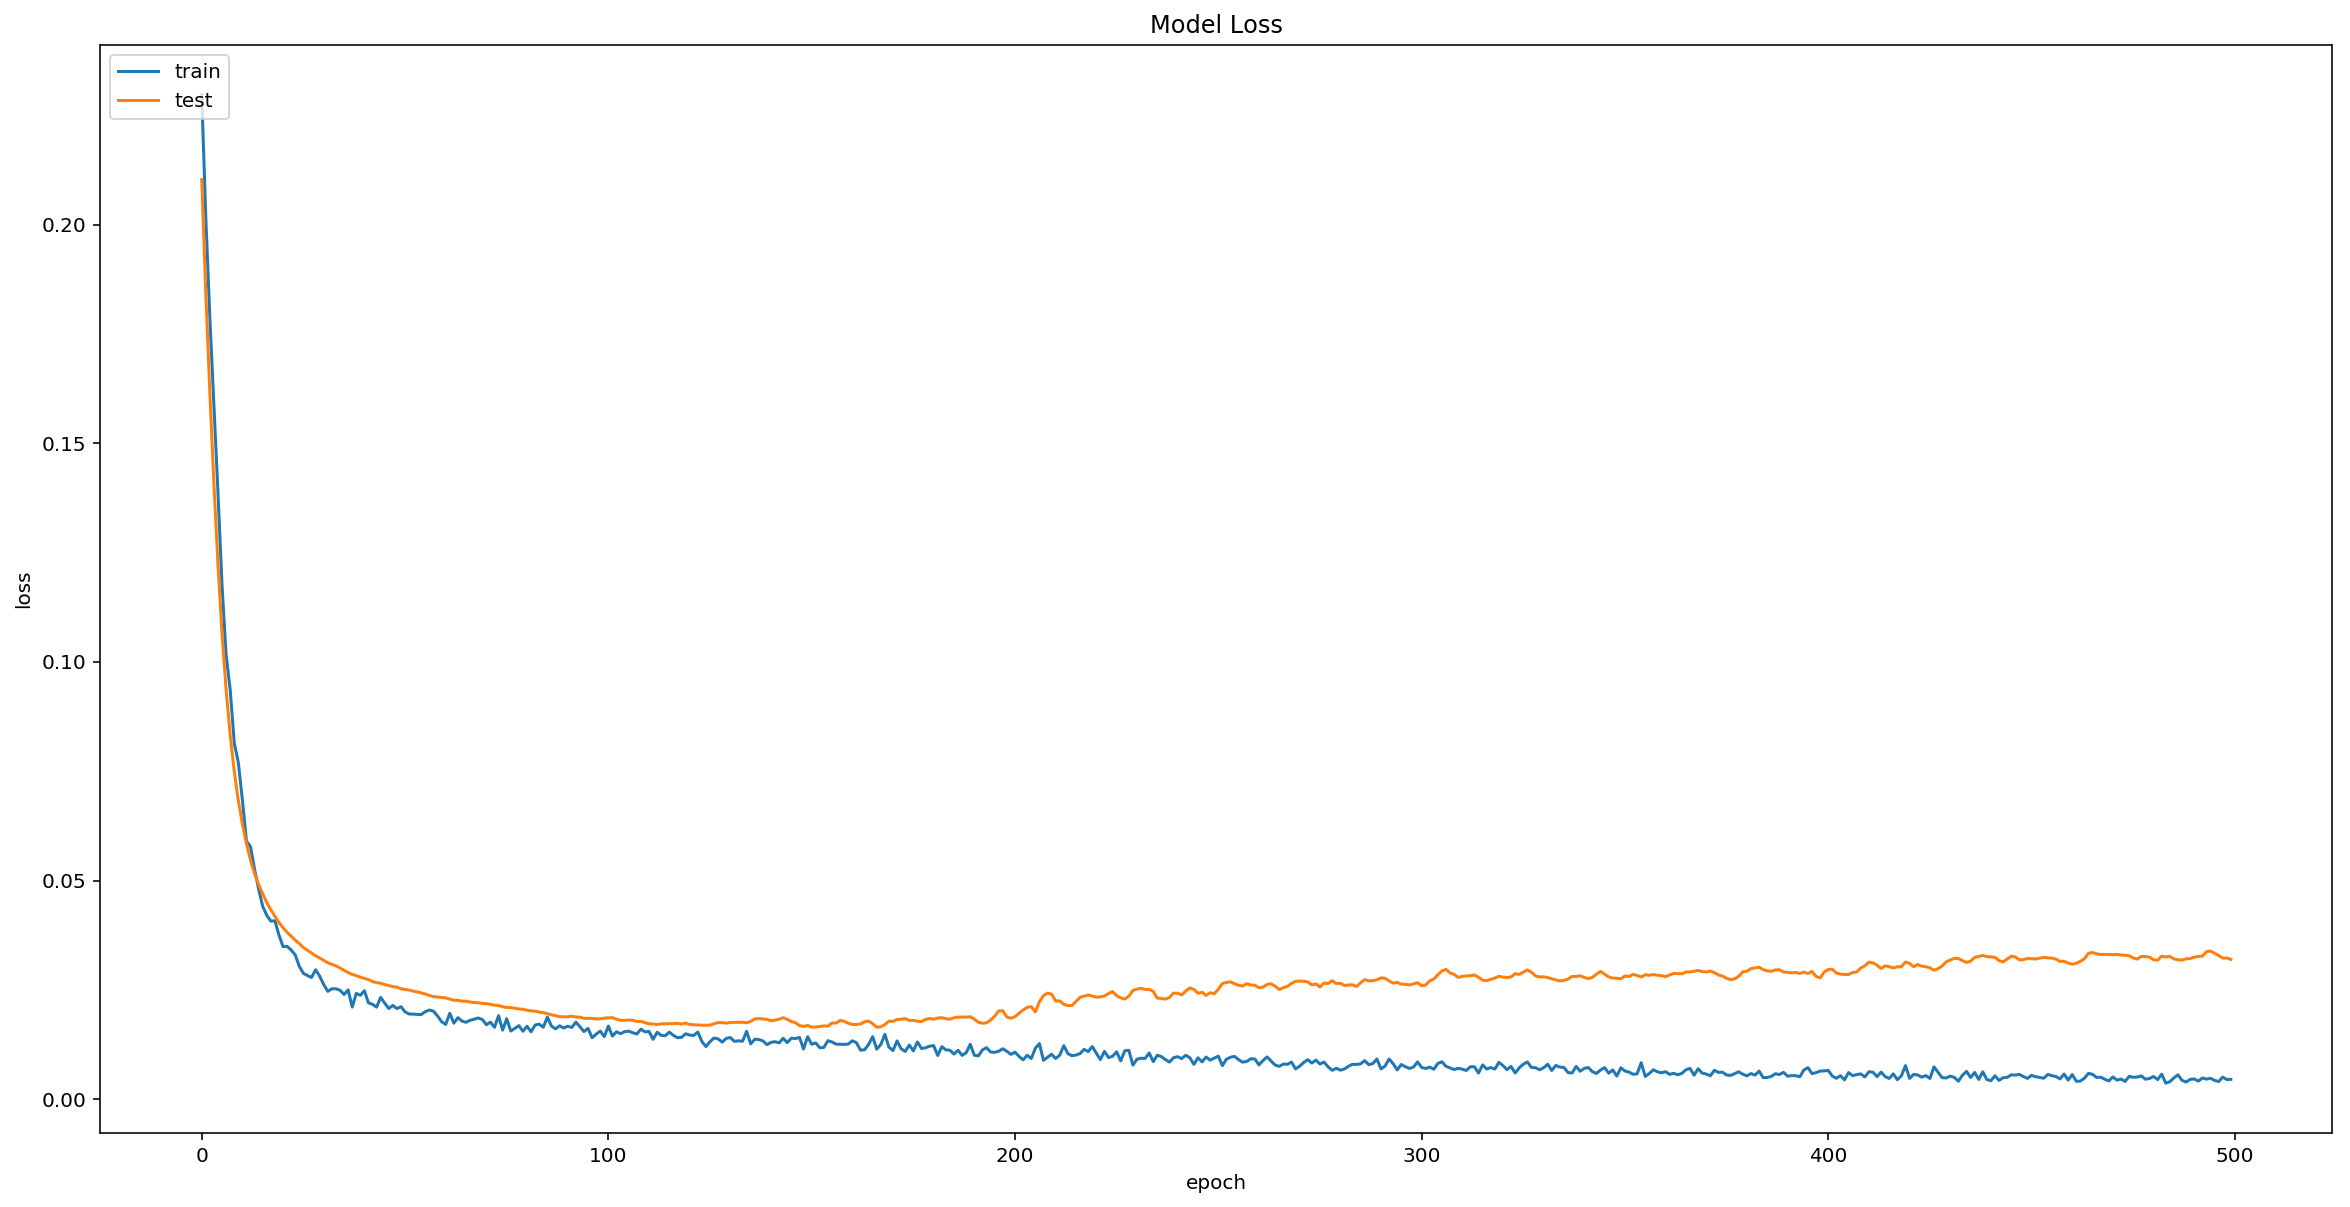

Memory Usage 1.48 MB
Time of Processing 18.66s
Accuracy 99.42%


In [77]:
show_info(model6, X_test_norm, y_test, keras_history6)

In [61]:
y_pred = (model6.predict(X_test_norm) > 0.5).astype(int)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.values.reshape(-1, 1), y_pred)

array([[108,   0],
       [  1,  62]])